STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas

Sebastian Raschka 

CPython 3.7.5
IPython 7.10.2

torch 1.4.0
pandas 0.25.3


<br>
<br>

# ADALINE Examples

![](images/adaline.png)

In [2]:
import torch
from torch.autograd import grad
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

<br>
<br>

## Dataset Prep

In [3]:
import pandas as pd

df = pd.read_csv('./datasets/iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)


# Assign features and target

X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

<br>
<br>

## 1) ADALINE Manually

In [4]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weight = torch.zeros(num_features, 1, 
                                  dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weight), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(y - yhat)
        
        grad_yhat_weights = -x
        grad_yhat_bias = -1.
        
        # Chain rule: inner times outer
        grad_loss_weights =  torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias
    
    
    
####################################################
##### Training and evaluation wrappers
###################################################

def loss_func(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weight += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            #### Logging ####
            #minibatch_loss = loss(yhat, y[minibatch_idx])
            #print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss_func(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

In [5]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 0.38849
Epoch: 002 | MSE: 0.31679
Epoch: 003 | MSE: 0.26379
Epoch: 004 | MSE: 0.22463
Epoch: 005 | MSE: 0.19527
Epoch: 006 | MSE: 0.17307
Epoch: 007 | MSE: 0.15629
Epoch: 008 | MSE: 0.14352
Epoch: 009 | MSE: 0.13360
Epoch: 010 | MSE: 0.12600
Epoch: 011 | MSE: 0.12007
Epoch: 012 | MSE: 0.11547
Epoch: 013 | MSE: 0.11178
Epoch: 014 | MSE: 0.10884
Epoch: 015 | MSE: 0.10656
Epoch: 016 | MSE: 0.10470
Epoch: 017 | MSE: 0.10320
Epoch: 018 | MSE: 0.10200
Epoch: 019 | MSE: 0.10105
Epoch: 020 | MSE: 0.10025


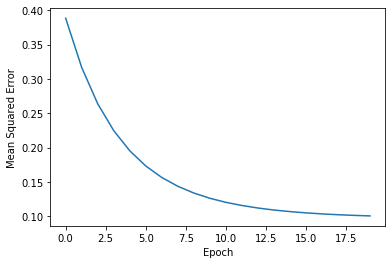

In [6]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [7]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.86
Test Accuracy: 93.33


<br>
<br>

## 2) ADALINE Semi-Manually (using Autograd)

In [8]:
class Adaline2():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weight = torch.zeros(num_features, 1, 
                                  dtype=torch.float,
                                  requires_grad=True)
        self.bias = torch.zeros(1, dtype=torch.float,
                                requires_grad=True)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weight), self.bias)
        activations = netinputs
        return activations.view(-1)

    
####################################################
##### Training and evaluation wrappers
###################################################

def loss_func(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])
            loss = loss_func(yhat, y[minibatch_idx])
            
            #### Compute gradients ####
            
            negative_grad_w = grad(loss, model.weight, retain_graph=True)[0] * (-1)
            negative_grad_b = grad(loss, model.bias)[0] * (-1)
            
            
            #### Update weights ####
            #model.weight += learning_rate * negative_grad_w
            #model.bias += learning_rate * negative_grad_b

            model.weight = model.weight + learning_rate * negative_grad_w
            model.bias = model.bias + learning_rate * negative_grad_b

        #### Logging ####
        with torch.no_grad():
            # context manager to
            # avoid building graph during "inference"
            # to save memory
            yhat = model.forward(x)
            curr_loss = loss_func(yhat, y)
            print('Epoch: %03d' % (e+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

In [9]:
model = Adaline2(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 0.38849
Epoch: 002 | MSE: 0.31679
Epoch: 003 | MSE: 0.26379
Epoch: 004 | MSE: 0.22463
Epoch: 005 | MSE: 0.19527
Epoch: 006 | MSE: 0.17307
Epoch: 007 | MSE: 0.15629
Epoch: 008 | MSE: 0.14352
Epoch: 009 | MSE: 0.13360
Epoch: 010 | MSE: 0.12600
Epoch: 011 | MSE: 0.12007
Epoch: 012 | MSE: 0.11547
Epoch: 013 | MSE: 0.11178
Epoch: 014 | MSE: 0.10884
Epoch: 015 | MSE: 0.10656
Epoch: 016 | MSE: 0.10470
Epoch: 017 | MSE: 0.10320
Epoch: 018 | MSE: 0.10200
Epoch: 019 | MSE: 0.10105
Epoch: 020 | MSE: 0.10025


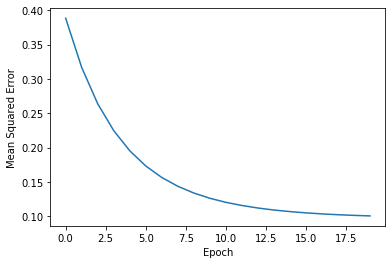

In [10]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [11]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.86
Test Accuracy: 93.33


<br>
<br>

## 3) ADALINE Automatically

In [12]:
class Adaline3(torch.nn.Module):
    def __init__(self, num_features):
        super(Adaline3, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        
        # change random weights to zero
        # (don't do this for multi-layer nets!)
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        netinputs = self.linear(x)
        activations = netinputs
        return activations.view(-1)

    
####################################################
##### Training and evaluation wrappers
###################################################


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])
            
            # you could also use our "manual" loss_func
            loss = F.mse_loss(yhat, y[minibatch_idx])
            
            #### Reset gradients from previous iteration ####
            optimizer.zero_grad()
            
            #### Compute gradients ####
            loss.backward()
            
            #### Update weights ####
            optimizer.step()

        #### Logging ####
        with torch.no_grad():
            # context manager to
            # avoid building graph during "inference"
            # to save memory
            yhat = model.forward(x)
            curr_loss = loss_func(yhat, y)
            print('Epoch: %03d' % (e+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

In [13]:
model = Adaline3(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 0.38849
Epoch: 002 | MSE: 0.31679
Epoch: 003 | MSE: 0.26379
Epoch: 004 | MSE: 0.22463
Epoch: 005 | MSE: 0.19527
Epoch: 006 | MSE: 0.17307
Epoch: 007 | MSE: 0.15629
Epoch: 008 | MSE: 0.14352
Epoch: 009 | MSE: 0.13360
Epoch: 010 | MSE: 0.12600
Epoch: 011 | MSE: 0.12007
Epoch: 012 | MSE: 0.11547
Epoch: 013 | MSE: 0.11178
Epoch: 014 | MSE: 0.10884
Epoch: 015 | MSE: 0.10656
Epoch: 016 | MSE: 0.10470
Epoch: 017 | MSE: 0.10320
Epoch: 018 | MSE: 0.10200
Epoch: 019 | MSE: 0.10105
Epoch: 020 | MSE: 0.10025


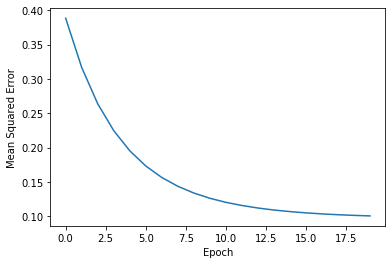

In [14]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [15]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.86
Test Accuracy: 93.33
